In [1]:
pip install opencv-python 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python matplotlib scikit-image numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-image matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from skimage.feature import graycoprops, graycomatrix
from skimage.io import imread
from skimage.filters import prewitt_h, prewitt_v
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torchvision import models
import torchvision.transforms as transforms

# Preprocessing

In [8]:
def load_images(dir_name):
    img_list = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    for item in os.listdir(dir_name):
        img_path = os.path.join(dir_name, item)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.GaussianBlur(img, (5, 5), 1)
            img = clahe.apply(img)
            img_list.append(img)
    return img_list

 
def find_edges(img_list):
    edges_list = []
    sigma = 0.33
    
    for img in img_list:
        v = np.median(img)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(max(0, (1.0 + sigma) * v))
        edges = cv2.Canny(img, lower, upper)
        edges_list.append(edges)
    return edges_list

# HOG Feature

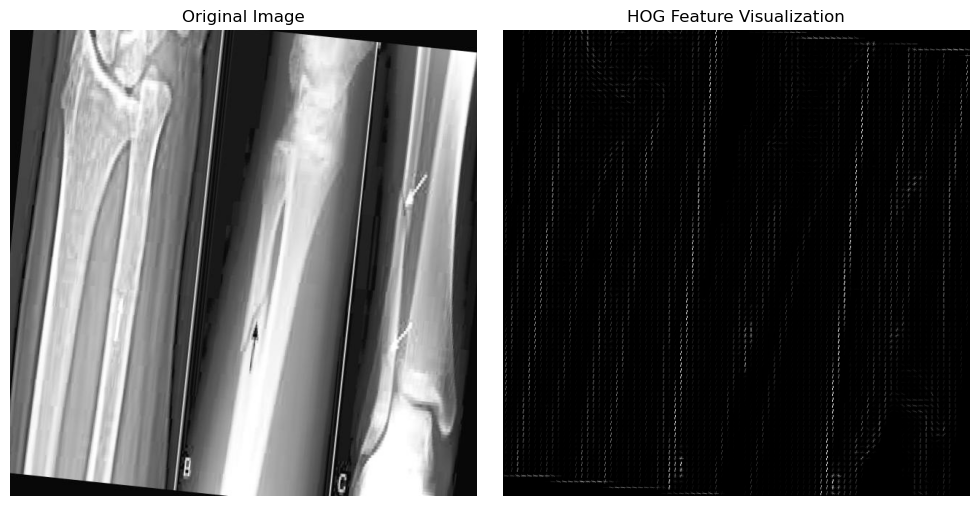

Total images processed for set 1: 316
Shape of first HOG feature vector for set 1: (224676,)


In [10]:
def extract_hog_features(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute HOG features with visualization
    fd, hog_image = hog(gray, 
                        orientations=9, 
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), 
                        visualize=True)
    
    return fd, hog_image

def load_images(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            full_path = os.path.join(directory, filename)
            image_paths.append(full_path)
    return image_paths

# Load images from different directories
image_list_1 = load_images("./data_xray/Impacted fracture")
image_list_2 = load_images("./data_xray/Intra-articular fracture")
image_list_3 = load_images("./data_xray/Longitudinal fracture")
image_list_4 = load_images("./data_xray/Oblique fracture")

# Extract HOG features for each list
hog_features_1 = [extract_hog_features(path)[0] for path in image_list_1]
hog_features_2 = [extract_hog_features(path)[0] for path in image_list_2]
hog_features_3 = [extract_hog_features(path)[0] for path in image_list_3]
hog_features_4 = [extract_hog_features(path)[0] for path in image_list_4]

# Visualization of HOG features for the first image set
if image_list_1:
    plt.figure(figsize=(10, 5))
    
    # Original image
    original_image = cv2.imread(image_list_1[0])
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image_rgb)
    plt.axis('off')
    
    # HOG visualization
    _, hog_image = extract_hog_features(image_list_1[0])
    plt.subplot(1, 2, 2)
    plt.title("HOG Feature Visualization")
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print(f"Total images processed for set 1: {len(image_list_1)}")
print(f"Shape of first HOG feature vector for set 1: {hog_features_1[0].shape}")

# Edge Extraction Features

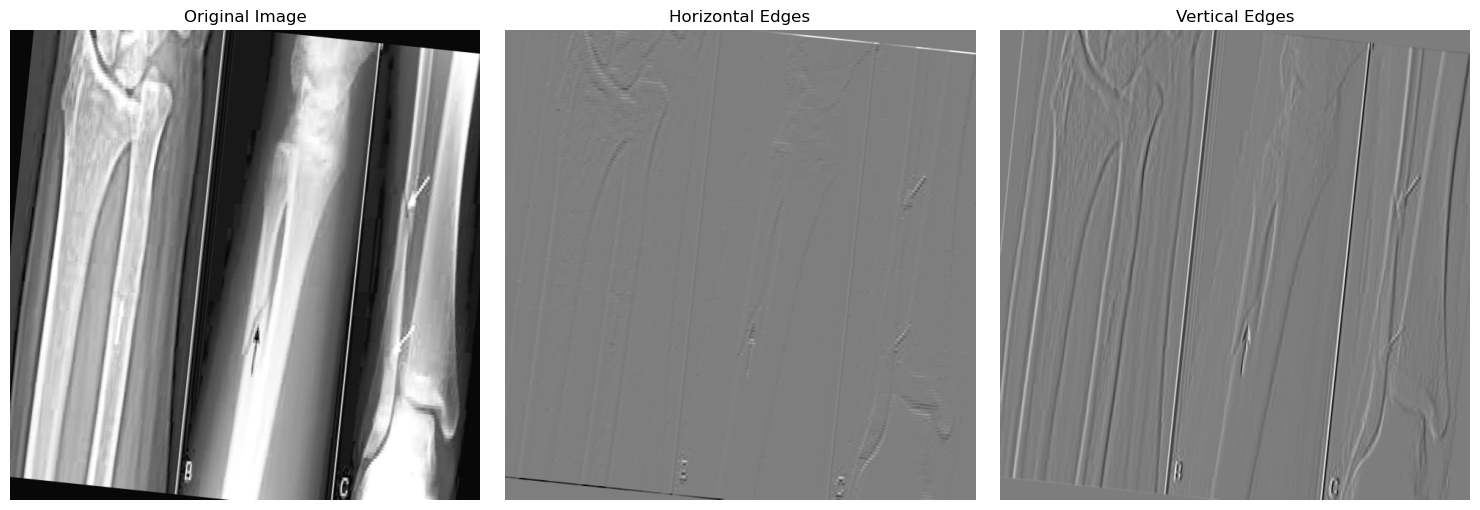

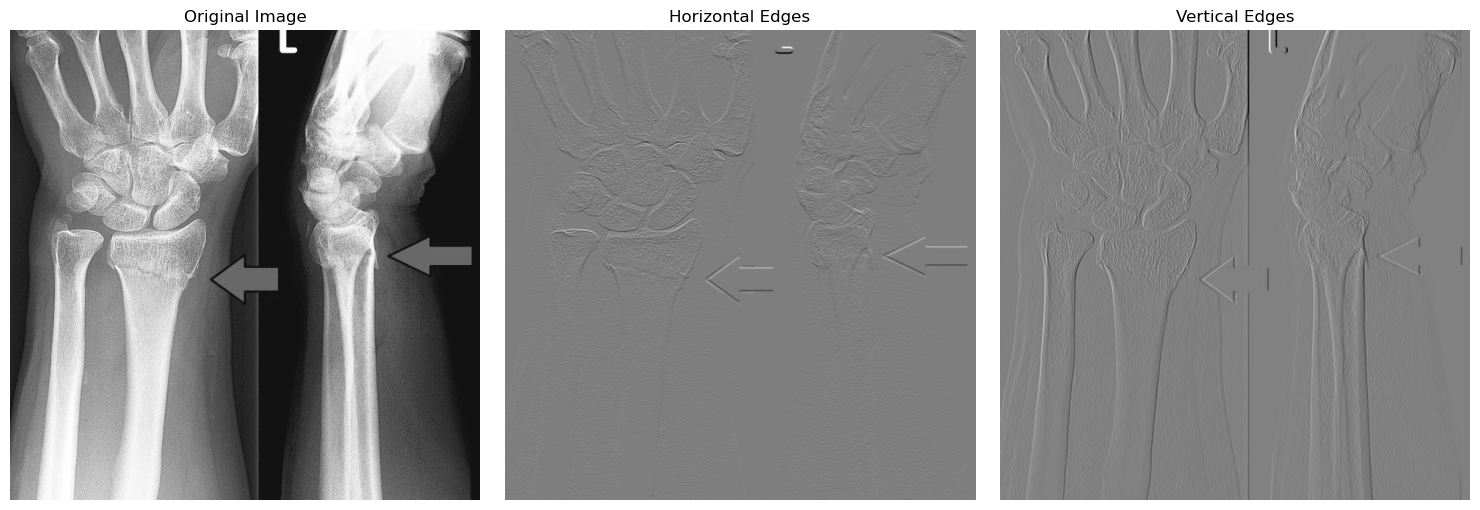

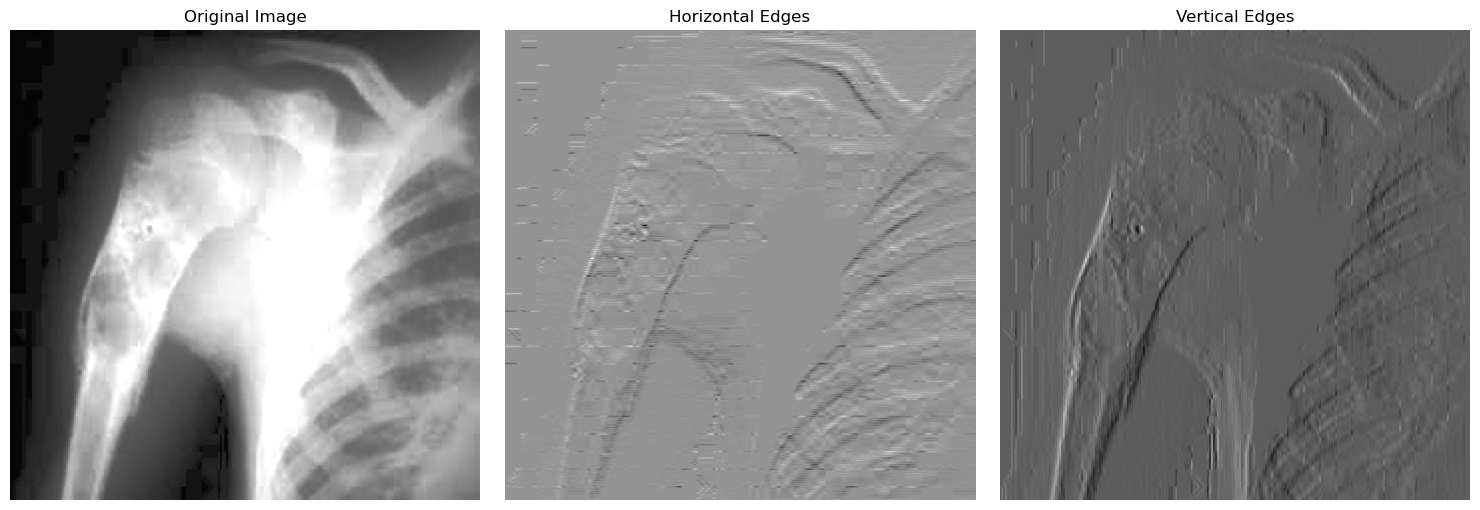

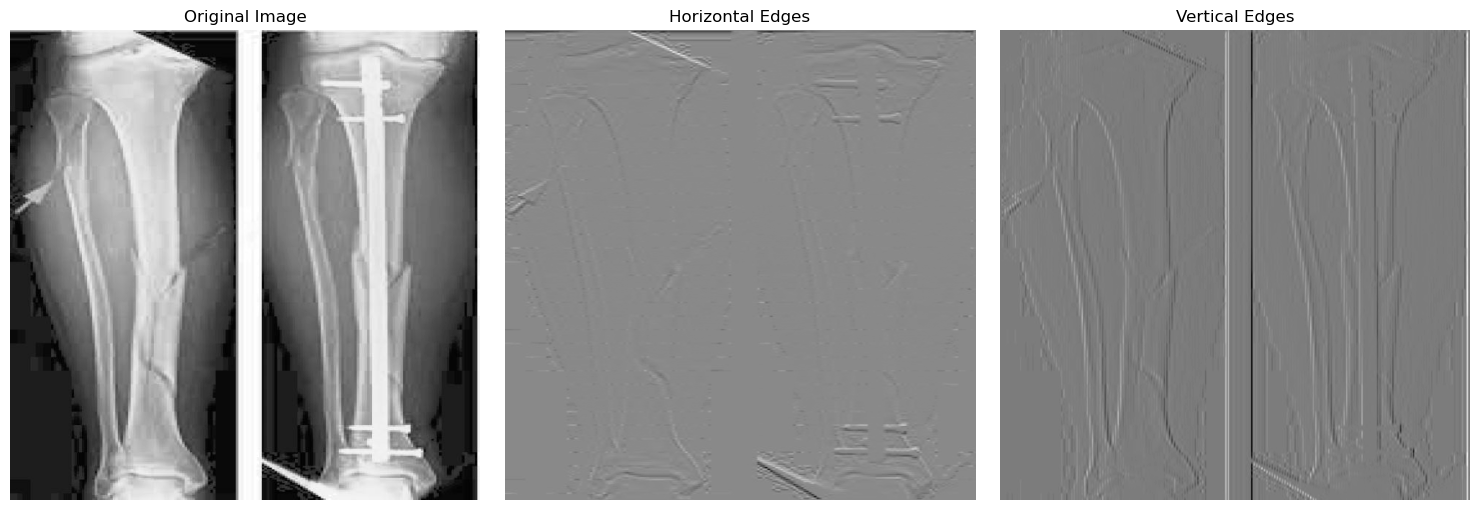

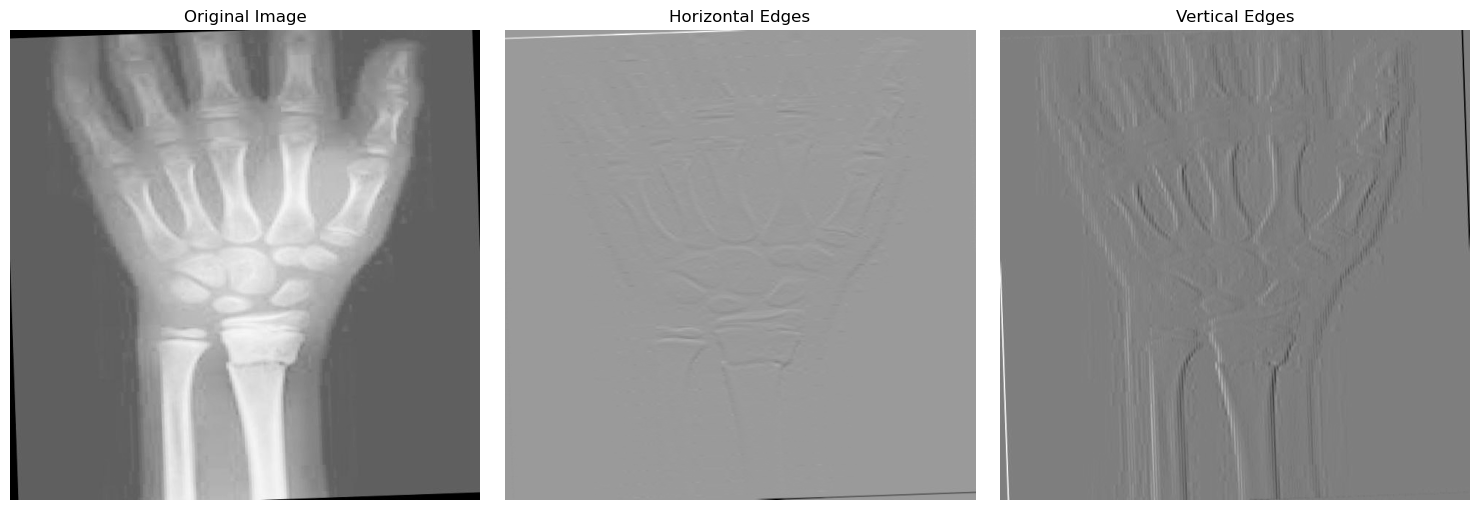

In [12]:
def perform_edge_detection(image_paths, num_to_display=5):
    for i, image_path in enumerate(image_paths[:num_to_display]):
        try:
            
            image = imread(image_path, as_gray=True)
            
            
            edges_horizontal = prewitt_h(image)
            edges_vertical = prewitt_v(image)
            
           
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Horizontal Edges")
            plt.imshow(edges_horizontal, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Vertical Edges")
            plt.imshow(edges_vertical, cmap='gray')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

image_list_1 = load_images('./data_xray/Impacted fracture') 
perform_edge_detection(image_list_1)

def extract_and_flatten_edge_features(image_paths):
    edge_features = []
    for image_path in image_paths:
        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            
            # Apply Canny edge detection
            v = np.median(image)
            sigma = 0.33
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(max(0, (1.0 + sigma) * v))
            edges = cv2.Canny(image, lower, upper)
            
            # Flatten edges to create feature vector
            edge_features.append(edges.flatten())
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return edge_features

# Feature Reduction - PCA

In [14]:
def apply_pca(features, n_components=0.95, return_pca=False):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)

    print(f"Explained variance by PCA: {sum(pca.explained_variance_ratio_):.2f}")
    
    if return_pca:
        return reduced_features, pca  # Return both reduced features and PCA object
    return reduced_features  # Return only reduced features

In [15]:
def plot_pca_variance(pca, title="PCA Explained Variance"):
    plt.figure(figsize=(10, 6))
    plt.plot(
        np.cumsum(pca.explained_variance_ratio_),
        marker='o',
        linestyle='--',
        color='b',
        label="Cumulative Explained Variance"
    )
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Classification

In [17]:
def classify_and_evaluate(features, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

   
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

In [18]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Testing - HOG Features

In [20]:
image_list_1 = load_images("./data_xray/Impacted fracture")
image_list_2 = load_images("./data_xray/Intra-articular fracture")

hog_features_1 = [extract_hog_features(path)[0] for path in image_list_1]
hog_features_2 = [extract_hog_features(path)[0] for path in image_list_2]

all_features = np.vstack((hog_features_1, hog_features_2))
all_labels = np.array([0] * len(hog_features_1) + [1] * len(hog_features_2))

In [21]:
# Apply PCA and Dimnesionality Reduction
reduced_features = apply_pca(all_features)
# Perform Classification and Evaluation
classify_and_evaluate(reduced_features, all_labels)

Explained variance by PCA: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        95
           1       0.82      0.59      0.69        39

    accuracy                           0.84       134
   macro avg       0.84      0.77      0.79       134
weighted avg       0.84      0.84      0.83       134

Confusion Matrix:
[[90  5]
 [16 23]]


# Testing - Edge Features

In [23]:
edge_features_1 = extract_and_flatten_edge_features(image_list_1)
edge_features_2 = extract_and_flatten_edge_features(image_list_2)

all_edge_features = np.vstack((edge_features_1, edge_features_2))
all_edge_labels = np.array([0] * len(edge_features_1) + [1] * len(edge_features_2))

In [24]:
# Apply PCA and Dimnesionality Reduction
reduced_edge_features, edge_pca = apply_pca(all_edge_features, return_pca=True)
# Perform Classification and Evaluation
classify_and_evaluate(reduced_edge_features, all_edge_labels)

Explained variance by PCA: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        95
           1       0.41      0.46      0.43        39

    accuracy                           0.65       134
   macro avg       0.59      0.59      0.59       134
weighted avg       0.66      0.65      0.66       134

Confusion Matrix:
[[69 26]
 [21 18]]


# Visualization

In [25]:
def view_corr(df, title="Feature Correlation Heatmap"):
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

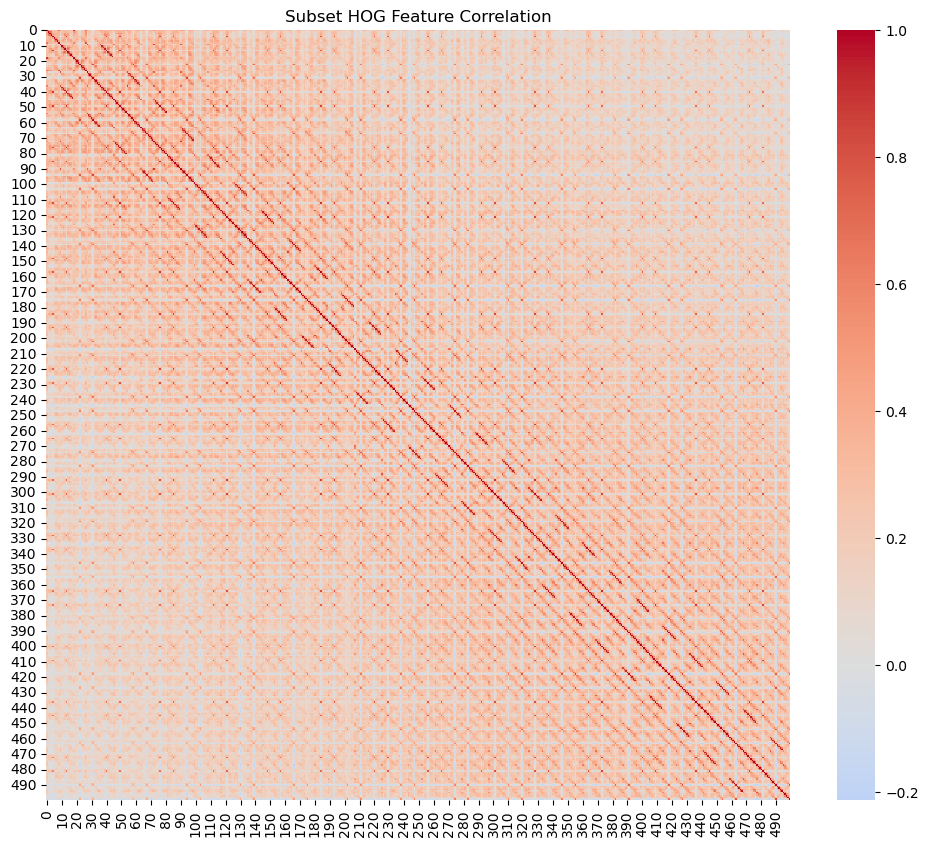

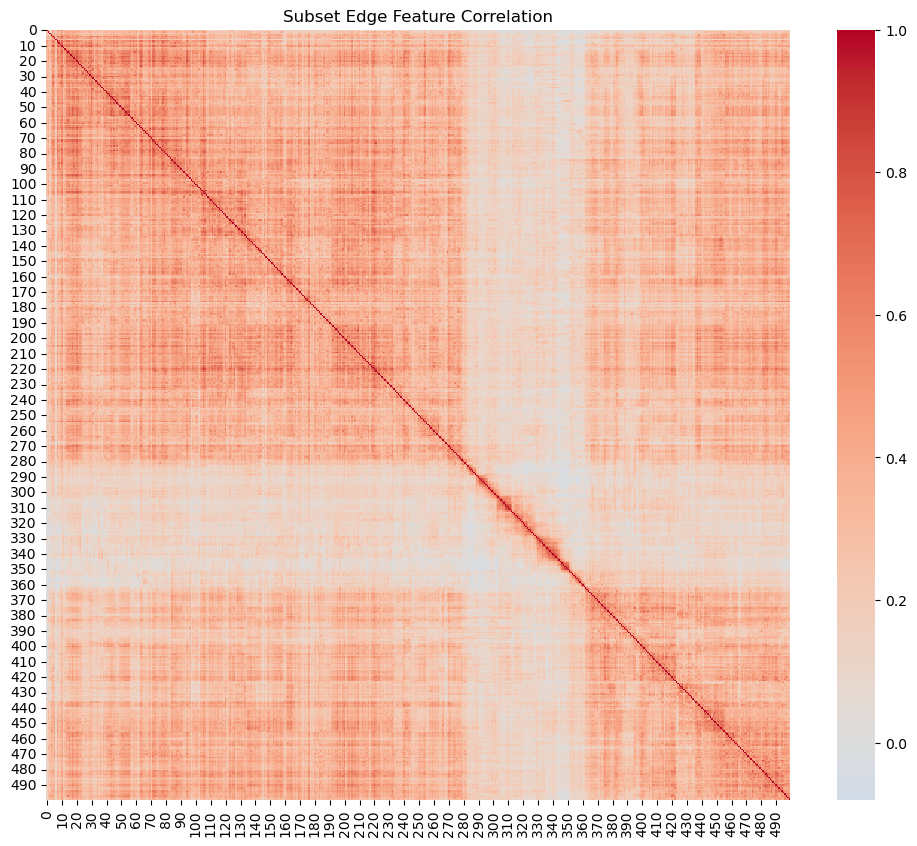

In [33]:
# Only using first 500 Features
hog_subset = all_features[:, :500] 
hog_df = pd.DataFrame(hog_subset)
view_corr(hog_df, title="Subset HOG Feature Correlation")

edge_subset = all_edge_features[:, :500]  
edge_df = pd.DataFrame(edge_subset)
view_corr(edge_df, title="Subset Edge Feature Correlation")